# problem

In this competition, the fifth iteration, you will use hierarchical sales data from Walmart, the world’s largest company by revenue, to forecast daily sales for the next 28 days. The data, covers stores in three US States (California, Texas, and Wisconsin) and includes item level, department, product categories, and store details. In addition, it has explanatory variables such as price, promotions, day of the week, and special events. Together, this robust dataset can be used to improve forecasting accuracy.

This competition uses a Weighted Root Mean Squared Scaled Error (RMSSE).

#### Submission

Each row contains an ```id``` that is a concatenation of an ```item_id``` and a ```store_id```, which is either ```validation``` (corresponding to the Public leaderboard), or ```evaluation``` (corresponding to the Private leaderboard). You are predicting 28 forecast days (```F1-F28```) of items sold for each row. For the validation rows, this corresponds to ```d_1914``` - ```d_1941```, and for the evaluation rows, this corresponds to ```d_1942``` - ```d_1969```. (Note: a month before the competition close, the ground truth for the validation rows will be provided.)

Predicting number of items sold for each category for days 1 to 28 in a month. Rolling forecast. 

#### Approach

(1) Get data into a long format, so that we can make time series graphs.
(2) Add the calendar and price datasets to the long format main dataset.
(3) Start most gross and then work into specifics. Look at trends over weeks in product sales.
(4) Group by product category.


#### Random thoughts
(1) These data are hierarchical, so using that hierachy in the model will help to simplify the model. 
(2) Can we combine a model that does weekly estimates with one that estimates for each day of the week? 

In [95]:
import pandas as pd
import numpy as np
import seaborn as sns
import datetime
%matplotlib inline
import matplotlib.pyplot as plt

In [4]:
calendar = pd.read_csv('data/calendar.csv')

Calendar maps dates onto days, weekday, months, years, special holidays.

In [76]:
calendar.head(5)

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,day_code
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0,1
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0,2
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0,3
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0,4
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1,5


In [73]:
calendar['day_code']= calendar['d'].str.lstrip('d_')

In [84]:
calendar['day_code'] = calendar['day_code'].astype(int)

In [15]:
sales_count = pd.read_csv('data/sales_train_validation.csv')

Sales train validation data tells us about number of products sold each day for each category: hobbies, household, foods. 

In [16]:
sales_count.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4


In [17]:
sales_prices = pd.read_csv('data/sell_prices.csv')

Sales prices tells us about price of each product for each week.

In [20]:
sales_prices.head()

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26


Let's do a time series graph of one product for one location to get the ball rolling. Let's make this a function to get some practice. 

We need to flip from wide to long format for the time series to work. 

Let's group by weeks to make this more managable to start with. 

In [71]:
sales_count_long = pd.wide_to_long(sales_count, stubnames='d', i=['item_id', 'store_id'], j='day',
                    sep='_', suffix='\w+')

In [72]:
sales_count_long = sales_count_long.drop(columns = ['dept_id', 'cat_id', 'id', 'state_id'])


In [82]:
sales_count_long = sales_count_long.reset_index()

In [80]:
sales_count_long.head()

,index,item_id,store_id,day,d
0,0,HOBBIES_1_001,CA_1,1,0
1,1,HOBBIES_1_001,CA_1,2,0
2,2,HOBBIES_1_001,CA_1,3,0
3,3,HOBBIES_1_001,CA_1,4,0
4,4,HOBBIES_1_001,CA_1,5,0


In [83]:
sales_count_long.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58327370 entries, 0 to 58327369
Data columns (total 6 columns):
level_0     int64
index       int64
item_id     object
store_id    object
day         int64
d           int64
dtypes: int64(4), object(2)
memory usage: 2.6+ GB


Now we merge the calendar info onto the sales_count_long dataset. 

In [85]:
sales_count_long_cal = pd.merge(sales_count_long, calendar, left_on = 'day', right_on = 'day_code')

In [115]:
sales_count_long_cal.head()

,level_0,index,item_id,store_id,day,d_x,date,wm_yr_wk,weekday,wday,...,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,day_code,occurred_at_week,product_type
0,0,0,HOBBIES_1_001,CA_1,1,0,2011-01-29,11101,Saturday,1,...,NaN,NaN,NaN,NaN,0,0,0,1,2011-01-24,"[HOBBIES, 1, 001]"
1,1913,1913,HOBBIES_1_002,CA_1,1,0,2011-01-29,11101,Saturday,1,...,NaN,NaN,NaN,NaN,0,0,0,1,2011-01-24,"[HOBBIES, 1, 002]"
2,3826,3826,HOBBIES_1_003,CA_1,1,0,2011-01-29,11101,Saturday,1,...,NaN,NaN,NaN,NaN,0,0,0,1,2011-01-24,"[HOBBIES, 1, 003]"
3,5739,5739,HOBBIES_1_004,CA_1,1,0,2011-01-29,11101,Saturday,1,...,NaN,NaN,NaN,NaN,0,0,0,1,2011-01-24,"[HOBBIES, 1, 004]"
4,7652,7652,HOBBIES_1_005,CA_1,1,0,2011-01-29,11101,Saturday,1,...,NaN,NaN,NaN,NaN,0,0,0,1,2011-01-24,"[HOBBIES, 1, 005]"


In [119]:
product_type = sales_count_long_cal['item_id'].str.split('_', n = 2)

In [118]:
sales_count_long_cal["product_category"]= product_type[0]
sales_count_long_cal["product_number"]= product_type[2]

ValueError: Length of values does not match length of index

Create a grouping variable for hobbies, food, and household.

In [109]:
sales_count_long_cal['product_type'] = np.where((sales_count_long_cal['item_id'] == 'HOBBIES.*'), 'HOBBIES', 'OTHER')
                                               #np.where((sales_count_long_cal['item_id'] == 'FOOD%', 'FOOD'), 'HOUSEHOLD'))

In [90]:
sales_count_long_cal['date'] = pd.to_datetime(sales_count_long_cal['date'])

In [91]:
sales_count_long_cal['occurred_at_week'] = sales_count_long_cal.date.dt.floor('D')- pd.to_timedelta(sales_count_long_cal['date'].dt.dayofweek, unit='d')

In [93]:
def plotProductCount(data, by, times = 'occured_at_week', kind='line', ax=None):
    ax = ax or plt.gca()
    myplot = data.groupby(times)[by].value_counts().unstack().plot(kind=kind,ax=ax)
    plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
    plt.title(by)
    plt.rcParams['figure.dpi'] = 100
    plt.figure(figsize=(6,4))
    return myplot

KeyError: 'occured_at_week'

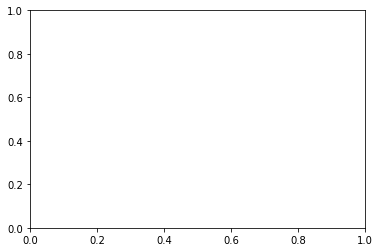

In [96]:
plotProductCount(sales_count_long_cal, 'store_id')

In [ ]:
from pandas import read_csv
from matplotlib import pyplot
series = read_csv('daily-minimum-temperatures.csv', header=0, index_col=0, parse_dates=True, squeeze=True)
series.plot()
pyplot.show()